# Starbucks Capstone Challenge

## Part 1. Introduction to the Project and Data
### 1. Project Overview
The dataset containing offer history and purchase behavior of Starbucks mobile app customers were provided by Starbucks. In this project, we will use the dataset to understand how customers responded to different types of offers and how much they spent with and without those offers. Furthermore, using demographic information provided by the customers, we will build machine learning models to predict if potentially new customers would respond to offers; if so, what type of offer would the customer most likely view and use.

### 2. Project goals
1. Analyze offer types and customers' response to the offers
2. Build machine learning (ML) model based on customer's demographic information and their response to offers
3. Predict future customer's response to given offer type using ML model

### 3. Datasets
The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open
* channels (list of strings) - web, email, mobile, social

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Part 2.  Data Analysis
### 1. Data exploration and cleaning

In this part, we will explore each dataset and perform basic data cleaning.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
profile.head() # take a loot at profile dataset

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile.isnull().sum() # check missing values

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

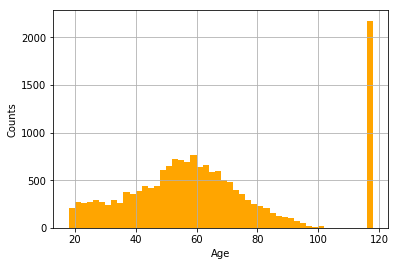

In [5]:
# check age distribution
profile.age.hist(bins=50,color='orange')
plt.xlabel('Age')
plt.ylabel('Counts'); 

In [6]:
# there are a bunch of 118 with no missing value, let see why
profile[profile.age==118].sample(5) 

,age,became_member_on,gender,id,income
7976,118,20171124,None,73614a26789a49daa79dcc26664c1b72,NaN
7097,118,20170526,None,d20e62e676c24f79a5bc82902dccd44c,NaN
13941,118,20170615,None,c9d4f7fea926489dafd3f4266df8b915,NaN
6671,118,20180410,None,ab530a4ad78d491aad5ba506b45d35f7,NaN
13064,118,20160117,None,3afdcadc6c364dbd93a68d29b6abbcb8,NaN


It looks like the system gives users age of 118 when they did not enter any demographic info (age, gender, income). We will deal with missing values later.

In [7]:
# 'became_member_on' column is string type
# we will transform it as datetime & ordinal
profile['became_member_on'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').date())
profile['membership'] = profile.became_member_on.apply(lambda x: x.toordinal())
profile.head()

,age,became_member_on,gender,id,income,membership
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,736372
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,736525
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,736887
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,736458
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,736545


In [8]:
portfolio # check out portfolio dataset

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [9]:
transcript.sample(5) # check out transcript dataset

,event,person,time,value
192789,transaction,b1627ee5584342b8bb5bfa43f9a9bbfc,468,{'amount': 5.99}
170085,transaction,330392fa98824cdebfcbdb514aa786dd,414,{'amount': 1.65}
69239,offer viewed,cceda95e6893423798bcdbb1e34ca003,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
152842,offer received,79258dac19b04f8297d03ffdaf1e80ba,408,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
83553,offer completed,b4c29d77c6d045698bf125545d1520f8,210,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [10]:
# looks like value column contains either offer info (id) or transaction amount ($)
# we will keep the values and get rid of the keys so that the col only contains offer id or dollar amount
transcript['detail'] = transcript.value.apply(lambda x: list(x.values())[0])
transcript.drop('value',axis=1,inplace=True)

# merge transcript and portfolio data
portfolio['duration'] = portfolio['duration'].apply(lambda x: int(24*x)) # change the unit of duration to hours
portfolio.columns = ['channels', 'difficulty', 'duration', 'detail', 'offer_type', 'reward']
transcript = pd.merge(transcript,portfolio,how='left',on='detail')

transcript.sample(5)

,event,person,time,detail,channels,difficulty,duration,offer_type,reward
243743,offer completed,ccbb447a19e04f7fa7a36dae6991b736,570,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10.0,168.0,bogo,10.0
8459,offer received,883154b582374762a496c60758780d64,0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,120.0,bogo,5.0
271405,offer completed,ed213022de554001874b97fcff479283,594,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10.0,168.0,bogo,10.0
49753,transaction,b390be062396490093121338df43f692,144,17.75,NaN,NaN,NaN,NaN,NaN
251731,offer received,1abf52a6ee1f44dd90ef5308bc8aa959,576,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,240.0,discount,2.0


In [11]:
# take a look events of a random person
transcript[transcript.person=='664f862d4d7b4d779778bf49d694697f'] # randomly selected id

,event,person,time,detail,channels,difficulty,duration,offer_type,reward
11462,offer received,664f862d4d7b4d779778bf49d694697f,0,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,72.0,informational,0.0
15502,offer viewed,664f862d4d7b4d779778bf49d694697f,0,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,72.0,informational,0.0
93637,transaction,664f862d4d7b4d779778bf49d694697f,240,27.16,NaN,NaN,NaN,NaN,NaN
98939,transaction,664f862d4d7b4d779778bf49d694697f,264,31.79,NaN,NaN,NaN,NaN,NaN
102609,transaction,664f862d4d7b4d779778bf49d694697f,282,20.57,NaN,NaN,NaN,NaN,NaN
122310,offer received,664f862d4d7b4d779778bf49d694697f,336,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10.0,168.0,bogo,10.0
139503,offer viewed,664f862d4d7b4d779778bf49d694697f,366,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10.0,168.0,bogo,10.0
218330,transaction,664f862d4d7b4d779778bf49d694697f,504,24.58,NaN,NaN,NaN,NaN,NaN
218331,offer completed,664f862d4d7b4d779778bf49d694697f,504,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10.0,168.0,bogo,10.0
225022,transaction,664f862d4d7b4d779778bf49d694697f,516,15.42,NaN,NaN,NaN,NaN,NaN


We will write above procedures (cleaning and merging) into a function for future use.

In [12]:
def data_clean(profile, portfolio, transcript):
    '''
    This function takes in profile, portfolio and transcript dataframes and perform basic data cleaning.
    
    inputs:
        1. profile - original profile df
        2. portfolio - portfolio df
        3. transcript - original transcript df
    
    outputs:
        1. profile - profile df with membership date transformed to datetime format as well as ordinal format
        2. transcript - transcript df cleaned & merged with portfolio df
    
    '''
    
    profile['became_member_on'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').date())
    profile['membership'] = profile.became_member_on.apply(lambda x: x.toordinal())

    transcript['detail'] = transcript.value.apply(lambda x: list(x.values())[0])
    transcript.drop('value',axis=1,inplace=True)

    portfolio['duration'] = portfolio['duration'].apply(lambda x: int(24*x)) # change the unit of duration to hours
    portfolio.columns = ['channels', 'difficulty', 'duration', 'detail', 'offer_type', 'reward']
    transcript = pd.merge(transcript,portfolio,how='left',on='detail')

    return profile, transcript

Now we can get all offer and purchase history of each customers. What we will do next is to collapse these events so that we can have summarized offer history and purchase behavior of each customer.

### 2. Data engineering

Summarize offer history and purchase behavior of all users.

Based on what we see from a person's events, it seems relatively easy to count how many offer the person received, how many were viewed or completed and how much total transaction was made by this person. The tricky part is to figure out how many completed offers were from offers that the person viewed beforehand. We have to pay extra attention when count the number of offers that were viewed and completed because some of the offers were completed first and then viewed afterwards; therefore, we have to differentiate 'viewed and completed' offers from 'completed and then viewed' ones. Also, calculating the transactions associated with viewed and completed vs. completed but not viewed (including viewed after completed) offers was not straitforward because for each transaction, we don't know if it was associated with a completed offer or not. 

It turns out that the 'time' column is extemely helpful to solve these issues. You'll notice for each completed offer, the time for offer completion and corresponding transaction is the same. Therefore, we will start from the time of events and figure out which transaction was associated with completed offer. Further, we'll also use the time to determine if the completed offer was viewed, and if so whether it was viewed before or after offer completion.

The following functions will be used to summarize the offer history associated with a person as well as transaction history associated with all the purchase made by that person.

In [13]:
def offer_analyzer(person_df,person,idx,offer,offer_record):
    '''
    This function takes in a person's events from transcript df and generate a df that includes the number and type
    of offer the person received, completed, viewed and completed as well as not viewed but completed. The function 
    also generates a df of all viewed and completed offers by all users for future use.
    
    inputs:
        1. person_df - all events of this person
        2. person - the person's id
        3. idx - index to keep track of for generating 'viewed & completed offer dataframe'
    
    outputs:
        1. [final] - a list of all output variables including:
           receive -- counts of offer received
           comp -- counts of offer completed
           view_comp -- counts of offer viewed and completed
           noview_comp -- counts of offer completed without viewing
           bogo -- counts of viewed & completed bogo offer
           discount -- counts of viewed & completed discount offer and
           10 columns for 10 types of offers-- how many times this specific offer was viewed & completed
        2. idx - updated index to keep track of for generating 'viewed & completed offer dataframe'
    '''

    # select all offers the person received
    offers = person_df[person_df.event=='offer received']
    
    # start counting
    comp = 0                   # completed offers
    view_comp = 0              # completed after view
    noview_comp = 0            # completed without view
    offer_list = []            # keep track of offer id
    offer_type_list = []       # keep track of offer type
    
    # loop through received offers and check if each offer was completed and/or viewed
    # 'start->end' is the time window in which an offer can be viewed & completed
    for i in range(len(offers)):
        id = offers.iloc[i]['detail'] # offer id
        start = offers.iloc[i]['time'] # time when this offer was received
        end = offers.iloc[i]['duration'] + start # end-point of this offer 
        
        # now check if this offer was viewed and/or completed
        viewed = 'offer viewed' in list(person_df[(person_df.time>=start)&(person_df.time<=end)&(person_df.detail==id)]['event'])
        completed = 'offer completed' in list(person_df[(person_df.time>=start)&(person_df.time<=end)&(person_df.detail==id)]['event'])
        
        if completed:
            comp +=1

            if viewed: 
                view_comp +=1
                offer_list.append(id)
                offer_type_list.append(portfolio[portfolio.detail==id]['offer_type'].iloc[0])
                idx_time = person_df[(person_df.time>=start)&(person_df.time<=end)&(person_df.detail==id)&(person_df.event=='offer completed')].iloc[0]['time']
                offer_record.iloc[idx] = [person,id,idx_time] # keep track of viewed & completed offers in this df
                idx +=1
            else: noview_comp +=1
           
    receive = len(offers)
    receive_bogo = list(offers.offer_type).count('bogo')
    receive_discount = list(offers.offer_type).count('discount')
    bogo = offer_type_list.count('bogo')
    discount = offer_type_list.count('discount')
    
    # count how many times each type of offer was viewed & completed
    # loop through 10 different offers
    counts = []
    for off in list(portfolio.detail): 
        counts.append(offer_list.count(off))
    
    final = [receive,receive_bogo,receive_discount,comp,view_comp,noview_comp,bogo,discount] + counts
    
    return final,idx,offer,offer_record

In [14]:
def get_offer_df(transcript):
    '''
    This function generates/modify 'offer' dataframe containing all offer history of all users, 
    and 'offer_record' dataframe containing all viewed & completed offers from all users.
    
    inputs: 
        1. transcript - events df
        2. offer - empty offer df
        3. offer_record - empty offer_record df
    
    outputs:
        1. offer - a dataframe containing all offer summaries of users; columns represent:
           [offers received; completed; viewed & completed; completed without viewing; viewed & completed bogo offer;
           viewed & completed discount offer; counts for each offer id (viewed and completed counts)]  
        2. offer_record - a dataframe containing records (offer id, time and person id) for all 
           viewed & completed offers
    '''


    # create empty offer and offer_record dataframes
    offer_record = pd.DataFrame(columns=['person','id','time'],index=range(len(transcript)))
    offer = pd.DataFrame(columns = ['receive','rec_bogo','rec_discount','comp','view_comp','noview_comp','bogo','discount',
                               'ae264e3637204a6fb9bb56bc8210ddfd','4d5c57ea9a6940dd891ad53e9dbe8da0',
                                '3f207df678b143eea3cee63160fa8bed','9b98b8c7a33c4b65b9aebfe6a799e6d9',
                               '0b1e1539f2cc45b7b9fa7c272da2e1d7','2298d6c36e964ae4a3e7e9706d1fb8c2',
                               'fafdcd668e3743c1bb461111dcafc2a4','5a8bc65990b245e5a138643cd4eb9837',
                               'f19421c1d4aa40978ebb69ca19b0e20d','2906b810c7d4411798c6938adc9daaa5']
                               ,index=list(transcript.person.unique()))
    
    persons = list(transcript.person.unique())
    idx = 0
    
    # loop through all users
    for person in persons:
        person_df = transcript[transcript.person==person]

        # use above function to parse offers of a user, and save the result in offer df
        final, idx, offer, offer_record = offer_analyzer(person_df,person,idx,offer,offer_record)
        offer.loc[person] = final
        
    offer = offer.reset_index()
        
    return offer, offer_record

In [15]:
# run function and get the dataframes modified!
offer, offer_record = get_offer_df(transcript)

# take a look at the offer df
offer.sample(5)

,index,receive,rec_bogo,rec_discount,comp,view_comp,noview_comp,bogo,discount,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
3831,2f62fe8c53e04f828e25f57df9d56282,4,1,3,3,3,0,1,2,0,1,0,0,0,1,0,0,0,1
14124,e1e614f30e9c45478d1c5aa8fe3c6dbb,4,2,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0
6182,991386e4c20041428093919ed3c8f2ba,5,3,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0
3923,f2c038ac9ea84e26bee2b0071be4edc6,4,1,2,2,1,1,0,1,0,0,0,0,0,1,0,0,0,0
13363,9e0091e205174cfe8b7f90089f32cca0,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The offer dataframe shows the number of total offers customers received, how many of them were completed and how many of them were 'viewed and completed' offers and how many were 'completed before viewed'. Moreover, the numbers of bogo and discount offers that were viewed and completed were also counted.

Similar to the offer analyzer, we will analyze the transaction history of all users using the following functions.

In [16]:
def transaction_calculator(person,offer_record,transaction):
    '''
    This function takes in a person's events and calculate the totoal transaction, transaction associated
    with viewed & completed offers and transaction associated with not viewed but completed offers.
    
    inputs:
        1. person - all events of the person
        2. offer_record - record of all viewed & completed offers, will be used to assess if a certain amount of 
           transaction is associated with viewed & completed offer
    
    outputs:
        1. [final] - a list including all output variables:
           total - total transaction made by this person
           view_comp - transaction associated with viewed and completed offers
           noview_comp - transaction associated with completed but not viewed offers
    '''

    # calculate total transaction made by this person
    trans = person[person['event']=='transaction'][['person','time','detail']] # all transactions
    total = trans['detail'].sum()

    # start calculating
    view_comp = 0
    noview_comp = 0 
    view = False
    comp = False
    
    # loop through transactions to see if they are associated with viewed & completed offer
    for i in range(len(trans)):
        time = trans.iloc[i]['time'] # time of this transaction
        amount = trans.iloc[i]['detail'] # amount of this transaction
        
        # check if there's any completed offer(s) at this transaction time
        comp_off = person[(person.time==time)&(person.event=='offer completed')] # completed offers df
        
        if len(comp_off) > 0:
            comp = True

            # check if the completed offer was viewed
            # if more than one offers were completed simultaneously, check if ANY of them were viewed
            for j in range(len(comp_off)):
                if ((offer_record.person==comp_off.iloc[j]['person'])&(offer_record.id==comp_off.iloc[j]['detail'])&
                (offer_record.time==comp_off.iloc[j]['time'])).any(): view = True
        
        # update transactions for viewed & completed offers as well as not viewed but completed offers
        if comp:
            if view: view_comp = view_comp + amount
            else: noview_comp = noview_comp + amount
        
        # reset the value for next transaction 
        view = False
        comp = False
           
    final = [total,view_comp,noview_comp]
    
    return final,transaction

In [17]:
def get_transaction_df(transcript):
    '''
    This function generates a transaction dataframe containing all purchase behavior of all users.
    
    inputs: 
        1. transcript - events df
        2. transaction - empty transaction df
    
    outputs:
        1. transaction_df - a dataframe contains all purchase behavior of all users including total transaction
           amount, transaction associated with viewed & compelted offers as well as transaction associated with
           not viewed but completed offers
    
    '''
    
    # create an empty transaction dataframe
    transaction = pd.DataFrame(columns = ['total','view_complete_tran','noview_complete_tran'], index=list(transcript.person.unique()))

    # loop through all users in transcript (which is also the overall users in profile)
    persons = list(transcript.person.unique())

    for person in persons:
        person_df = transcript[transcript.person==person]
        
        # use above function to parse transaction and save the result in transaction df
        final,transaction = transaction_calculator(person_df,offer_record,transaction)
        transaction.loc[person] = final
        
    transaction = transaction.reset_index()
    
    return transaction

In [18]:
# run the function and get the transaction df modified!
transaction = get_transaction_df(transcript)

# take a look at the transaction df
transaction.sample(5)

,index,total,view_complete_tran,noview_complete_tran
7517,139ba634b97a48699224973289e3b484,189.93,69.09,0
11595,111b775a2e034c70b33a94936c2a0a73,157.32,43.77,25.54
13632,dedd0c6bc7344b4486a5eb1743e3da34,175.8,108.25,0
1830,dc7a7cf01f4040438ead2495de0372c2,42.5,6.46,10.59
10395,d414804ad97c44eb8e6b7400792be0bc,42.26,8.28,0


The transaction dataframe shows total transaction made by each customer, total transaction associated with viewed and completed offers as well as total transaction associated with completed but not viewed offers.

### 3. Analyses of users' offer history and purchase behavior 

Now we have summarized offer and transaction history of all users. Let's try to do some basic analyses to answer a few questions related to offer and purchase behavior.

In [19]:
# groupby the offer by offer id
offer_type_df = pd.merge(pd.DataFrame(offer.sum()[9:].sort_values(ascending=False)),portfolio,how='left',left_index=True,right_on='detail')
offer_type_df = pd.merge(offer_type_df,pd.DataFrame(transcript[transcript.event=='offer received'].groupby('detail').count()['event']),how='left',on='detail')
offer_type_df.columns = ['completed','channels', 'difficulty','duration','detail','offer_type','reward','received']
offer_type_df = offer_type_df[['received','completed','offer_type','difficulty','reward','channels', 'duration','detail']]
offer_type_df['completed'] = offer_type_df.completed.astype(np.int64)
offer_type_df

,received,completed,offer_type,difficulty,reward,channels,duration,detail
0,7597,5202,discount,10,2,"[web, email, mobile, social]",240,fafdcd668e3743c1bb461111dcafc2a4
1,7646,5011,discount,7,3,"[web, email, mobile, social]",168,2298d6c36e964ae4a3e7e9706d1fb8c2
2,7571,4150,bogo,5,5,"[web, email, mobile, social]",120,f19421c1d4aa40978ebb69ca19b0e20d
3,7658,3253,bogo,10,10,"[email, mobile, social]",168,ae264e3637204a6fb9bb56bc8210ddfd
4,7593,3227,bogo,10,10,"[web, email, mobile, social]",120,4d5c57ea9a6940dd891ad53e9dbe8da0
5,7677,2742,bogo,5,5,"[web, email, mobile]",168,9b98b8c7a33c4b65b9aebfe6a799e6d9
6,7632,2688,discount,10,2,"[web, email, mobile]",168,2906b810c7d4411798c6938adc9daaa5
7,7668,1624,discount,20,5,"[web, email]",240,0b1e1539f2cc45b7b9fa7c272da2e1d7
8,7618,0,informational,0,0,"[email, mobile, social]",72,5a8bc65990b245e5a138643cd4eb9837
9,7617,0,informational,0,0,"[web, email, mobile]",96,3f207df678b143eea3cee63160fa8bed


***

#### *Q1. Which offer was most completed by customers? Is one type of offer better than the other?*

In [46]:
offer_rank = offer_type_df[['offer_type','difficulty','reward','received','completed']].sort_values('completed',ascending=False)
offer_rank = offer_rank.groupby(['offer_type','difficulty','reward']).sum().reset_index()
offer_rank['completed_%'] = offer_rank.completed/offer_rank.received*100
offer_rank.sort_values('completed_%',ascending=False)

,offer_type,difficulty,reward,received,completed,completed_%
2,discount,7,3,7646,5011,65.537536
3,discount,10,2,15229,7890,51.809049
0,bogo,5,5,15248,6892,45.199370
1,bogo,10,10,15251,6480,42.489017
4,discount,20,5,7668,1624,21.178925
5,informational,0,0,15235,0,0.000000


In [21]:
# group the offers by type
type_p = offer_type_df.groupby('offer_type').sum()[['received','completed']]
type_p['completed_%'] = round(type_p.completed/type_p.received*100,1)
type_p.iloc[:2]

,received,completed,completed_%
offer_type,,,
bogo,30499,13372,43.8
discount,30543,14525,47.6


#### Answer to Q1:
    
*As you can see from first table, most completed offers are two bogo offers. It makes sense because these two offers were most received ones. But by percentage, discount offers are more popular. Therefore, we could say that customers prefer discount offers than bogo offers.*

***

#### *Q2: What channel is best for delivering offers?*

In [22]:
# count the channels via which the offers were delivered and completed
channel_r = []
channel = []
for i in offer_type_df.index:
    channel_r = channel_r + offer_type_df.iloc[i]['received']*offer_type_df.iloc[i]['channels']
    channel = channel + offer_type_df.iloc[i]['completed']*offer_type_df.iloc[i]['channels']

channel_r = Counter(channel_r)
channel = Counter(channel)
channel_df = pd.DataFrame(columns=channel.keys(),index=['received','completed','completed_%'])

for col in channel_df.columns:
    channel_df[col]['received'] = channel_r[col]
    channel_df[col]['completed'] = channel[col]
channel_df.loc['completed_%'] = channel_df.loc['completed']/channel_df.loc['received']*100
channel_df

,web,email,mobile,social
received,61001,76277,68609,45683
completed,24644,27897,26273,20843
completed_%,40.3993,36.5733,38.2938,45.6253


#### Answer to Q2: 

*From the number/counts, we can see that email and mobile offers are most sent and most completed offers. But by percentage, most effective channels for delivering offers are social and web.*

***

#### *Q3: If we devide the offers by difficulty, what type of offer is most popular?*

In [23]:
# group the offers by difficulty
diff_p = offer_type_df.groupby('difficulty').sum()[['received','completed']]
diff_p['completed_%'] = round(diff_p.completed/diff_p.received*100,1)
diff_p.iloc[1:]

,received,completed,completed_%
difficulty,,,
5,15248,6892,45.2
7,7646,5011,65.5
10,30480,14370,47.1
20,7668,1624,21.2


#### Answer to Q3:

*We can see that most of the offers (except for information offers) sent to customers are 10 dollar offers (50%). The rest of the offers are 5 dollar offers (25%), 7 dollars and 20 dollars offers (12.5% each). The number/counts of completed offers follow the same trend. However, from the percentage of completion, we can see that customers prefer 7 dollar offers - more than 65% of 7 dollar offers were completed while 51% of 10 dollar offers and 45% of 10 dollar offers were completed. Not surprisingly, 20 dollar offer was the least popular one.*

***

#### *Q4: How many people never respond to any offer? And how many of them are loyal customers who always respond to offers?*

In [24]:
print(offer[offer.view_comp==0].shape[0],offer[offer.view_comp==0].shape[0]/offer.shape[0])
print(offer[offer.view_comp==offer.receive].shape[0],offer[offer.view_comp==offer.receive].shape[0]/offer.shape[0])

4877 0.2868823529411765
1065 0.06264705882352942


#### Answer to Q4:

*The number of people who never completed a single offer is 4877 (28.7%) while the number of people who completed all received offers is 1065 (6.3%).*

***

#### *Q5: How much transaction is associated with viewed and completed offer? What is its percentage compared to total transaction?*

In [25]:
print(transaction.sum()['view_complete_tran'])
print(transaction.sum()['view_complete_tran']/transaction.sum()['total']*100)

524567.1399999994
29.54555509603547


#### Answer to Q5:
    
*The total amount of transaction related to viewed and completed offer is 524567 dollars. This is about 30% of the total transaction.*

***

#### *Q6: Can we visualize the relationship between demographic info and transaction? What can we see from the plot?*

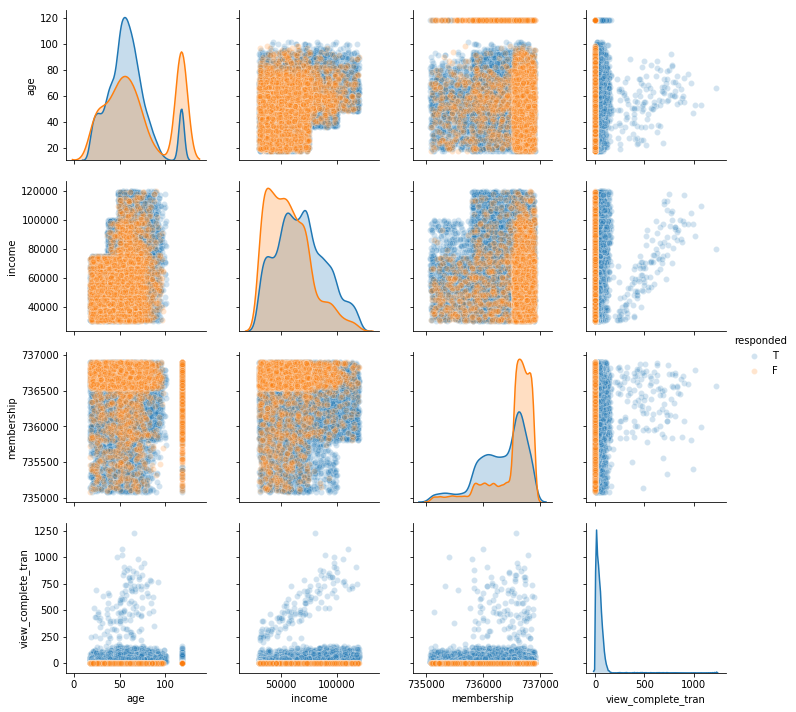

In [26]:
import warnings
warnings.filterwarnings('ignore') # turn off warning on missing values
pro = pd.merge(profile,transaction[['index','view_complete_tran']],left_on='id',right_on='index').drop('index',axis=1)
pro['responded'] = pro.view_complete_tran.apply(lambda x: 'T' if x!=0 else 'F')
sns.pairplot(pro,hue='responded',hue_order=['T','F'],plot_kws=dict(alpha=0.2),dropna=True);

#### Answer to Q6:
    
*We can clearly see some interesting patterns from the plot above. It looks like for some people, viewed and completed transaction is definitely related to age, income and duration of membership. However, there are also a separate group of people whose transaction amount and response to offer was not affected by age, income or membership duration. A group of people who never respond to a single offer (orange) tend to be mobile members for a short time period and have low income. Moreover, people who did not provide their info in the mobile app are less likely to respond to offers.*

## Part 3. Build Machine Learning Model to Predict Customer Behavior

In this part, we will build ML model using customers' profile and transaction data. Specifically, because we want to predict whether a future customer would respond to a certain type of offer or not, we will use demograhic information as well as offer type as input features and use response (binary label--responded/not responded) as target variable.

In order to do this, we will do some feature engineering before we try out various ML algorithms to train/test the model.

In [27]:
# first, import all necessary libraries in this part
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


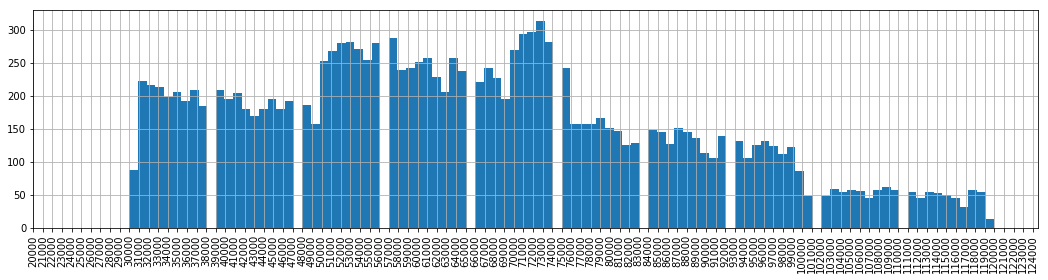

In [28]:
# take a deeper look at the income distribution
plt.figure(figsize=(18,4))
profile.income.hist(bins=100)
plt.xticks(list(range(20000,125000,1000)),rotation=90);

The income shows an interesting distribution pattern - the $1000 gaps in income separate customers into 10 groups. So we will use this pattern to make the income as an interval variable.

In [29]:
# create interval index for income column
left = pd.interval_range(start=0,end=30000,periods=1,closed='left')
middle = pd.interval_range(start=30000,end=120000,periods=10,closed='left')
right = pd.interval_range(start=120000,end=2**32,periods=1,closed='left')
income = list(left)+list(middle)+list(right)
income_interval = pd.IntervalIndex(income)
print(income_interval)
print('\n')
print('Number of interval categories is:', len(income_interval))

IntervalIndex([[0, 30000), [30000, 39000), [39000, 48000), [48000, 57000), [57000, 66000) ... [84000, 93000), [93000, 102000), [102000, 111000), [111000, 120000), [120000, 4294967296)]
              closed='left',
              dtype='interval[int64]')


Number of interval categories is: 12


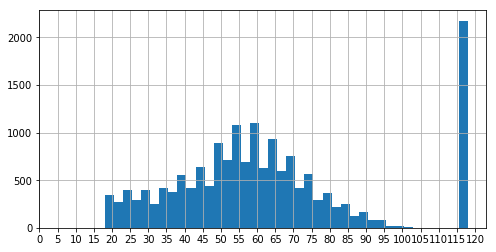

In [30]:
# next, check out age distribution
plt.figure(figsize=(8,4))
profile.age.hist(bins=40)
plt.xticks(list(range(0,125,5)));

We will create similar interval variable for age column.

In [31]:
left = pd.interval_range(start=0,end=20,periods=1,closed='left')
middle = pd.interval_range(start=20,end=110,freq=10,closed='left')
right = pd.interval_range(start=110,end=200,periods=1,closed='left')
age = list(left)+list(middle)+list(right)
age_interval = pd.IntervalIndex(age)
print(age_interval)
print('\n')
print('Number of interval categories is:', len(age_interval))

IntervalIndex([[0, 20), [20, 30), [30, 40), [40, 50), [50, 60) ... [70, 80), [80, 90), [90, 100), [100, 110), [110, 200)]
              closed='left',
              dtype='interval[int64]')


Number of interval categories is: 11


In [32]:
# finally, check the number of people that never received any offer
offer[offer.receive==0].shape[0] 

6

Because these 6 customers never recieved any offer, we will exclude them from training/test.

In [33]:
def get_df(profile,offer):
    
    '''
    This function takes in profile and offer dataframes and returns training and test datasets for ML.
    
    inputs: 
        1. profile - profile dataframe
        2. offer - offer dataframe
    
    outputs:
        1. X_train, X_test, y_train, y_test - input data for training and test, target label for training and test
        2. age_interval, income_interval - interval index for age and income variables
    '''
    
    # transform features and label
    demo = profile.copy()
    demo = demo[demo.id.isin(list(offer[offer.receive==0]['index']))==False] # exclude people never received an offer
    demo['member_year'] = demo.became_member_on.apply(lambda x: x.year)
    demo['member_month'] = demo.became_member_on.apply(lambda x: x.month)
    demo.drop('became_member_on',axis=1,inplace=True)
    
    # create 'offer' and 'label' columns: offer col has two values (bogo or discount) and label col shows whether 
    # the user responded to the offer or not
    bogo = offer[offer.rec_bogo!=0][['index','bogo']]
    bogo['label'] = bogo.bogo.apply(lambda x: 0 if x==0 else 1)
    bogo.drop('bogo',axis=1,inplace=True)
    bogo = demo.merge(bogo,left_on='id',right_on='index').drop('index',axis=1)
    bogo['offer'] = 'bogo'

    discount = offer[offer.rec_discount!=0][['index','discount']]
    discount['label'] = discount.discount.apply(lambda x: 0 if x==0 else 1)
    discount.drop('discount',axis=1,inplace=True)
    discount = demo.merge(discount,left_on='id',right_on='index').drop('index',axis=1)
    discount['offer'] = 'discount'
    
    # concat bogo and discount df
    df = pd.concat([bogo,discount]).drop('id',axis=1)
    df.age.replace(118,np.NaN,inplace=True)

    # transform features as interval category
    left = pd.interval_range(start=0,end=30000,periods=1,closed='left')
    middle = pd.interval_range(start=30000,end=120000,periods=10,closed='left')
    right = pd.interval_range(start=120000,end=2**32,periods=1,closed='left')
    income = list(left)+list(middle)+list(right)
    income_interval = pd.IntervalIndex(income)

    left = pd.interval_range(start=0,end=15,periods=1,closed='left')
    middle = pd.interval_range(start=15,end=115,freq=5,closed='left')
    right = pd.interval_range(start=115,end=200,periods=1,closed='left')
    age = list(left)+list(middle)+list(right)
    age_interval = pd.IntervalIndex(age)    

    df['age'] = pd.cut(df.age,age_interval)
    df['income'] = pd.cut(df.income,income_interval)
    
    # creat dummy variables
    df = pd.get_dummies(df,columns=['age','gender','income','member_year','member_month','offer'],dummy_na=True)
    
    # assign X and y
    X = df.drop('label',axis=1)
    y = df['label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        
    return X_train, X_test, y_train, y_test, age_interval, income_interval

In [34]:
# run the function above to get X, y and interval index for later use
X_train, X_test, y_train, y_test, age_interval, income_interval = get_df(profile,offer)

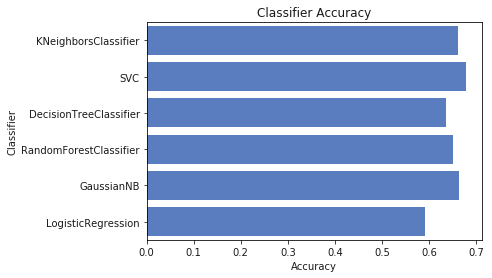

In [35]:
# Let's check out which classifier will work best in our case
classifiers = [KNeighborsClassifier(),
                SVC(probability=True),
                DecisionTreeClassifier(),
                RandomForestClassifier(),
                GaussianNB(),
                LogisticRegression()]

X_train, X_test, y_train, y_test, _, _ = get_df(profile,offer)

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf]
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b");

In [36]:
param = {'svc__C': [0.01,0.1,1,10],
         'svc__gamma': [0.01,0.1,1,10],
         'svc__kernel':['rbf']}

pipeline = Pipeline([('scale', MinMaxScaler()),
                     ('svc', SVC())])

grid_svc = GridSearchCV(estimator=pipeline,param_grid=param,scoring='accuracy',cv=5)
grid_svc.fit(X_train,y_train)

print('Training accuracy is:', grid_svc.score(X_train,y_train))
print('Test accuracy is:', grid_svc.score(X_test,y_test))

Training accuracy is: 0.7136244333094727
Test accuracy is: 0.7107548430193721


In [37]:
grid_svc.best_params_

{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

In [38]:
model = grid_svc.best_estimator_

In [39]:
def customer_transform(customer,offer_type,age_interval=age_interval,income_interval=income_interval):
    '''
    This function takes in a customers info and offer type and transform it to the same format as training data.
    
    inputs: 
    1. customer - customer's info, the same format as original profile df
    2. offer_type - 'bogo' or 'discount'
    3. age_interval, income_interval - interval index for age and income variables
    
    outputs:
    customer_df - customer's demographic info & offer type in the same format as X_train 

    '''
    
    # First, let's check whether the customer provided demographic info or not
    if customer['age']==118 or customer.isnull().any(): demo = False
    else: demo = True
    

    # Creat new customer df and tranform datetime col
    cols = get_df(profile,offer)[0].columns
    customer_df = pd.DataFrame(columns=cols,index=[0])
    year = datetime.datetime.strptime(str(customer['became_member_on']),'%Y%m%d').date().year
    month = datetime.datetime.strptime(str(customer['became_member_on']),'%Y%m%d').date().month

    customer_df['member_year_' + str(str(float(year)))] = 1
    customer_df['member_month_' + str(str(float(month)))] = 1
    customer_df['membership'] = datetime.datetime.strptime(str(customer['became_member_on']),'%Y%m%d').date().toordinal()
    
    if demo:
        # transform demo info if provided
        
        gender = customer['gender']
        customer_df['gender_' + str(gender)] = 1
        age = pd.get_dummies(pd.cut([customer['age']],age_interval),prefix='age')
        customer_df[age.columns] = age
        income = pd.get_dummies(pd.cut([customer['income']],income_interval),prefix='income')
        customer_df[income.columns] = income
        customer_df['offer_' + offer_type] = 1
     
    else:
        customer_df['age_nan'] = 1
        customer_df['gender_nan'] = 1
        customer_df['income_nan'] = 1
        customer_df['offer_' + offer_type] = 1

    
    customer_df.fillna(0,inplace=True)
    
    return customer_df

In [40]:
def predict(model, customer, offer_type):
    
    '''
    This function takes in profile and transcript dataframe and returns trained machine learning model.
    
    inputs: 
    1. model - profile dataframe
    2. customer - customer info, in the original 'profile' format
    3. offer_type - 'bogo' or 'discount'
    
    outputs:
    prediction - whether the customer would respond to given offer or not
    
    '''
    
    _, _, _, _, age_interval, income_interval = get_df(profile,offer)
    to_pred = customer_transform(customer,offer_type,age_interval,income_interval)
    pred = model.predict(to_pred)[0]
    
    if pred==0: print('We predict that the customer will not respond to given offer.')
    else: print('We predict that the customer will respond to given offer.')

Now we have all necessary functions for reading in data, cleaning data, train/test and predict response. We will see if they work just as we wanted!

In [41]:
# read in the json files and do data transform 
customers_profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [42]:
customer = customers_profile.sample(1).iloc[0]

In [43]:
customer # check this customer's info

age                                               59
became_member_on                            20161213
gender                                             F
id                  ea1564ae2fe34244b13f1dd5903b6af4
income                                         76000
Name: 4329, dtype: object

In [44]:
predict(model, customer, 'bogo') # let's predict this customer's response to a bogo offer

We predict that the customer will respond to given offer.


In [45]:
predict(model, customer, 'discount') # let's predict this customer's response to a discount offer

We predict that the customer will respond to given offer.


## Part 4. Discussion

In this project, we used Starbucks mobile customers' demographic information, offer and transaction history to build a machine learning model that can be used to predict whether a future customer will respond to a certain type of offer or not. 

There are a few important points we would like to discuss in this part. First, all customers have membership date so we need to utilize this information properly. We can either transform this datetime variable to categorical (year, month and day as separate variable or each day as separate variable), interval or continuous (ordinal). In our case, we transformed datetime variable to both categorical (year and month as separate categories, ignore day) and continuous variable (ordinal). In this way, we will have less categories (than using year, month and day all as separate categories), but will be able to catch the linear trend in datetime. 

Secondly, because offers could be completed even without viewing, we needed to differentiate offers that were viewed and completed from offers completed but not viewed. So we applied a series of heuristics within the created function to decide if a completed offer was actually viewed. Moreover, since the transcript data does not show us if a transaction is associated with an (completed) offer, we also need to figure out by comparing offer completion and transaction time. Finally, there are cases where a transaction was associated with several offers, for example a  singel transaction satisfied both bogo and discount offer. In this case, we considered the transaction (the whole transaction amount) as viewed and completed. However, when counting offers, we only count the viewed offer as viewed and completed. 

Finally, some customers did not provide any demographic info, so we need to either drop them in building ml model or treat them as a separate category (NaN category). Our purpose was to predict customer's possible reaction to certain offer, so it is highly possible that we will have future customers with no demographic info. So even without any info, we still have to be able to predict customer's response using membership date. Therefore, even though including customer with missing info will decrease accuracy in our model, we still wanted to include them. 


In conclusion, our model uses customers' demographic info to predict whether they will respond to 'bogo' or 'discount' offer. Of course there are other ways to build similar ml model. For example, predicting customer's transaction (on completed offers) or predicting the number of completed offers by the customers would also be a great idea because in this way we could be able to know how likely a person will respond to this offer instead of making simple binary (respond or not) decision. 